In [5]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from tqdm import tqdm
import pickle
import pandas as pd

pd.options.display.max_rows = 35 
pd.options.display.max_columns = None

In [6]:
def get_pickles(): 
    x_train = pickle.load(open(f'../../data/processed/pickles/x_train.p', 'rb'))
    x_test = pickle.load(open(f'../../data/processed/pickles/x_test.p', 'rb'))
    y_train = pickle.load(open(f'../../data/processed/pickles/y_train.p', 'rb'))
    y_test = pickle.load(open(f'../../data/processed/pickles/y_test.p', 'rb'))
    X = pickle.load(open('../../data/processed/pickles/X.p', 'rb'))
    y = pickle.load(open('../../data/processed/pickles/y.p', 'rb'))

    return (x_train, x_test, y_train, y_test), (X,y)

(x_train, x_test, y_train, y_test), (X,y) = get_pickles()


print(f'Original X: {X.shape}\tOriginal y: {y.shape}')
print(f'Train X: {x_train.shape}\tTrain y: {y_train.shape}')
print(f'Test X: {x_test.shape}\tTest y: {y_test.shape}')

Original X: (57247, 53)	Original y: (57247, 1)
Train X: (48659, 53)	Train y: (48659, 1)
Test X: (8588, 53)	Test y: (8588, 1)


In [7]:
y_train = y_train.target.values.ravel()
y_test = y_test.target.values.ravel()
y = y.target.values.ravel()

### Baseline Testing for Models and Stacked

In [8]:

models = {'log': LogisticRegression(), 
          'knn': KNeighborsClassifier(),
          'dt': DecisionTreeClassifier(), 'Gaussian': GaussianNB(), 'LDA': LinearDiscriminantAnalysis(),
          'rf': RandomForestClassifier(),
            }
#create stacked model
stack_m = [] 
for model, m in models.items(): 
    stack_m.append((model, m))
stack_model = StackingClassifier(estimators = stack_m, final_estimator = LogisticRegression(), cv = 5)
models['stacked'] = stack_model

#test each model and stacking
results = []
model_names = []
pbar = tqdm(models.items())
for model, m in pbar: 
    pbar.set_description(f'Evaluating {model.upper()}')
    cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 7, random_state = 10)
    scores = cross_val_score(m, X, y, scoring = 'accuracy', cv = cv, n_jobs = -1, 
                             error_score = 'raise')
    results.append(scores)
    model_names.append(model)
    

Evaluating STACKED: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [16:13<00:00, 139.06s/it]


In [9]:
vanilla_dict = {i:y for i,y in zip(model_names, results)}
pickle.dump(vanilla_dict, open('../../models/VanillaResults.p', 'wb'))

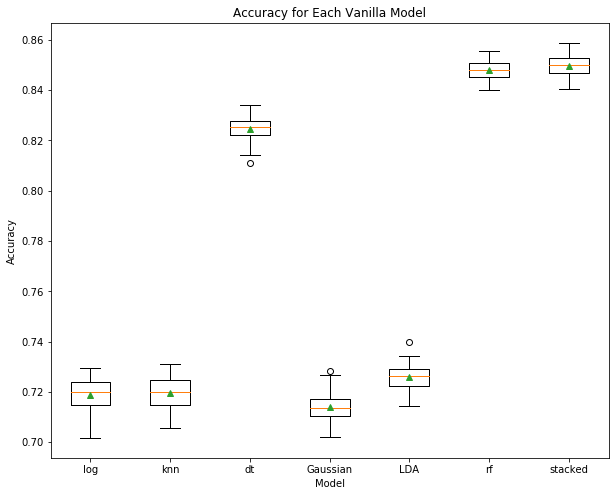

In [10]:
plt.figure(figsize = (10,8))
plt.boxplot(results, labels = model_names, showmeans = True)
plt.title('Accuracy for Each Vanilla Model')
plt.ylabel('Accuracy'); plt.xlabel('Model')
plt.savefig('figures/BaselineAccuracy.png')
plt.show()

In [ ]:
# svm = SVC(cache_size = 800, verbose = True)
# svm.fit(x_train, y_train)
# cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 5, random_state = 10)
# lda_scores = cross_val_score(SVC(), X, y, scoring = 'accuracy', cv = cv, n_jobs = -1, 
#                              error_score = 'raise')

# plt.boxplot([lda_scores], labels = ['LDA'], showmeans = True)
# plt.title('Accuracy for Each Vanilla Model')
# plt.ylabel('Accuracy'); plt.xlabel('Model')
# plt.savefig('figures/BaselineAccuracy.png')
# plt.show()

[LibSVM]

In [9]:
assert False

AssertionError: 

### Decision Tree and Random Forest Hyperparameter Tuning

In [3]:
# base_forest = RandomForestClassifier()
# base_forest.fit(x_train, y_train) 
# base_forest_predict = base_forest.predict(x_test, random_state = 100)
# base_cm = classification_report(y_test, base_forest_predict)
# print(base_cm)
# print(base_forest.estimators_)

param_grid = {
    'n_estimators': [50, 75, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 50, 100, 500],
    'max_features': [None,'auto', 'sqrt', 'log2'],
    'min_samples_leaf': [1,5], 
    'bootstrap': [True, False]
}
tuned_forest = RandomForestClassifier()
gs = GridSearchCV(tuned_forest, param_grid, verbose = 1, n_jobs =-1)
gs.fit(x_train, y_train) 


Fitting 5 folds for each of 384 candidates, totalling 1920 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   48.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed: 20.7min
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed: 31.5min
[Parallel(n_jobs=-1)]: Done 1920 out of 1920 | elapsed: 34.2min finished
c:\users\heeeb\anaconda3\envs\codeacademy\lib\site-packages\sklearn\model_selection\_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=No...
                                              random_state=None, verbose=0,
                                   

In [4]:
pickle.dump(gs, open('../../models/RFGridSearch.p', 'wb'))

In [12]:
gs.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=50, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)